# Image Classification

<div class="alert alert-info">
The <b>goal</b> of this notebook is to show you how you can <b>train your own model</b> to <b>classify images of your chosen categories</b>.
</div>

## Preparation of the programming environment

First things first, let's initiate a few libraries that we need during our analyis.

In [1]:
#@title Setup Google Colab by running this cell {display-mode: "form"}
import sys
if 'google.colab' in sys.modules:
    
    # Clone GitHub repository
    !git clone https://github.com/miykael/amld20_classification.git
        
    # Copy files required to run the code
    !cp -r 'amld20_classification/downloads' 'amld20_classification/utils.py' .
    
    # Install packages via pip
    !pip install -r "amld20_classification/colab-requirements.txt"
    
    # Restart Runtime
    import os
    os.kill(os.getpid(), 9)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

import numpy as np
import pandas as pd
from utils import *

# 1. Data Preparation

## 1.1. Define Class Labels

In [3]:
# List of class labels used for the classifcation
class_labels = [
               'brown bear',
               'polar bear',
               'giant panda',
               'red panda',
               'lion',
               'tiger',
               'racoon',
               'red fox',
               ]

<div class="alert alert-success">
<b>Note</b>: Feel free to change the list of class labels above as you want. It is recommended to have something between 4-8 classes.
    
<b>However</b>, for a smooth workshop experience, I recommend to keep the labels that are already listed and to only add a maximum of 4 more labels.
</div>

## 1.2. Collect Dataset

We will create the dataset for this classification ourselves by using google's image search page. The quickest way to do so is to use the python package [Google Images Download](https://github.com/hardikvasa/google-images-download).

In [4]:
# Collect the dataset and load the images
imgs_raw = collect_images(class_labels, suffix='photo,close up,portrait')

---
A Total of N=4449 images were collected!


<div class="alert alert-success">
<b>Note</b>: The parameter <code>suffix='photo,close up,portrait'</code> in the previous function is used to expand our image search requests with additional terms. As it is specified now, the code will look for images for "brown bear photo", "brown bear close up" and "brown bear portrait".
</div>

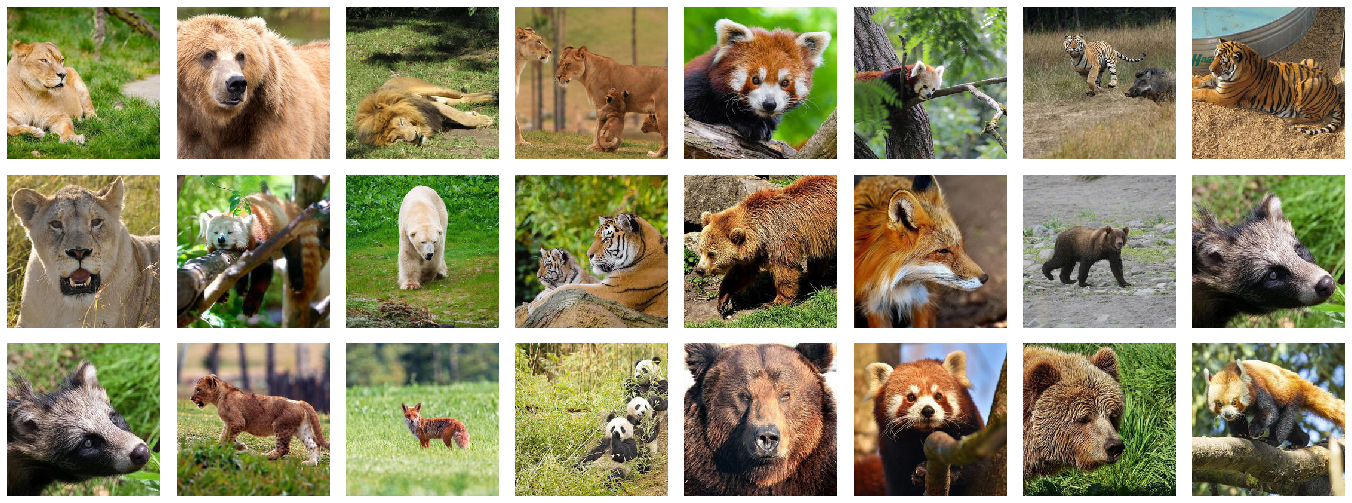

In [5]:
# Let's take a look at the data we've collected
plot_images(imgs_raw, n_col=8, n_row=3)

## 1.3. Clean Dataset

In [6]:
# Remove duplicates from the dataset
imgs_unique = remove_duplicates(imgs_raw)

Total number of images in the dataset: 4449
Number of duplicates in the dataset:      0


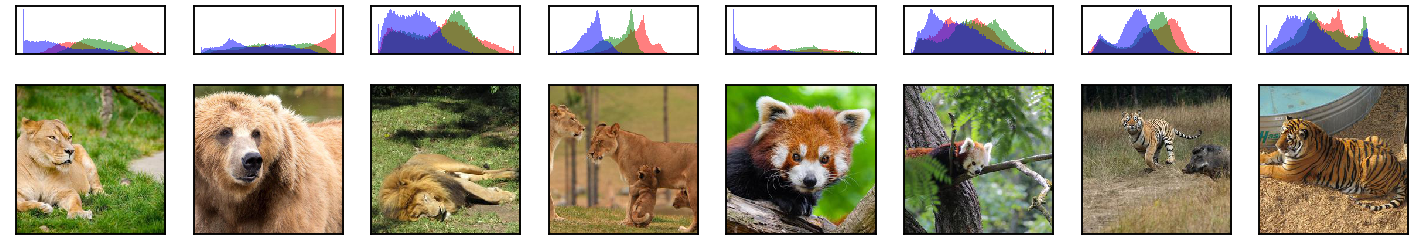

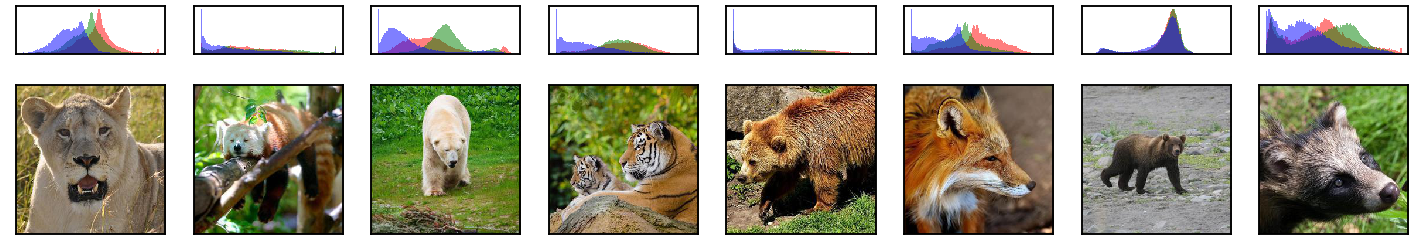

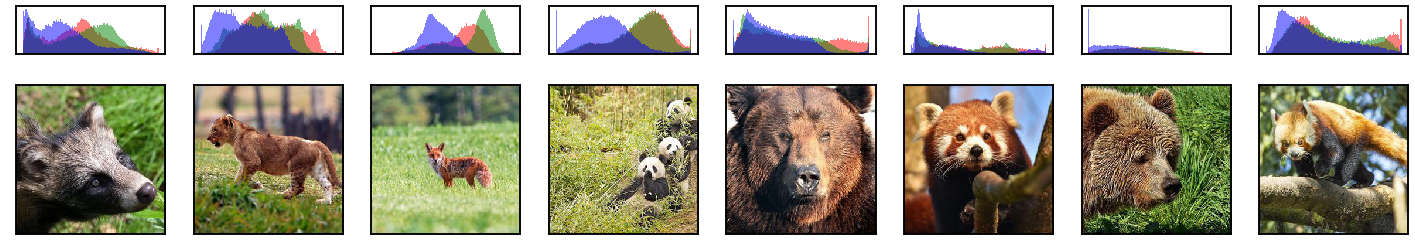

In [7]:
# Inspect images with their RGB color distributions
plot_images(imgs_unique, n_col=8, n_row=3, show_histogram=True)

<div class="alert alert-success">
<b>Note</b>: For this visualization, we set the parameter <code>show_histogram=True</code> to true, so that the color distributions for Red, Green and Blue are visualized as well. Keep in mind that setting this parameter to true slightly increases the visualization time.
</div>

In [8]:
# Remove outliers
imgs_clean, imgs_outlier = remove_outliers(imgs_unique)


Total number of images in the dataset: 4449
Number of outliers in the dataset:      344


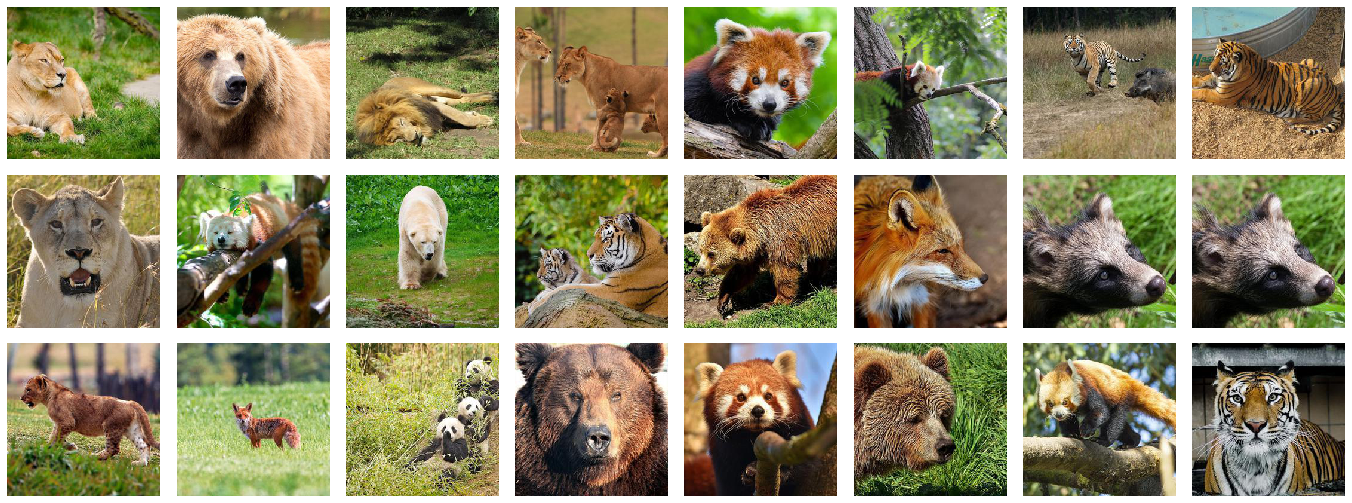

In [9]:
# Plot clean images
plot_images(imgs_clean, n_col=8, n_row=3)

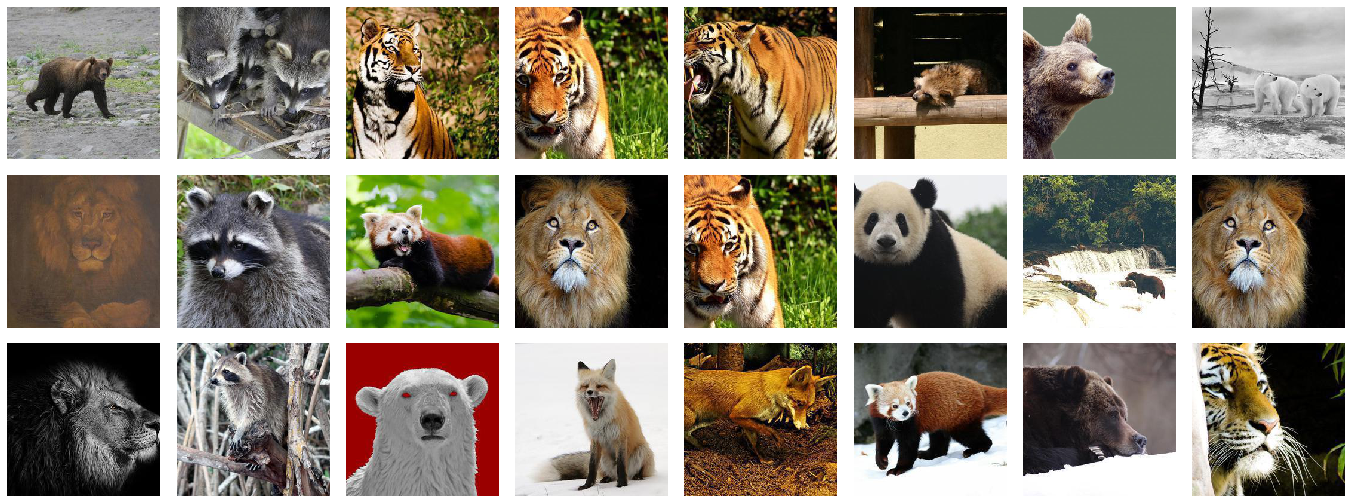

In [10]:
# Plot outlier images
plot_images(imgs_outlier, n_col=8, n_row=3)

## 1.4 Finalize Dataset

In [11]:
# Create dataset
X_pixel, y_pixel, metainfo = create_dataset(imgs_clean, class_labels, img_dim=32)

Found 4105 images belonging to 8 classes.



Images resampled to a resolution of 32 x 32!


# 2. Data Exploration

## 2.1. Data Description

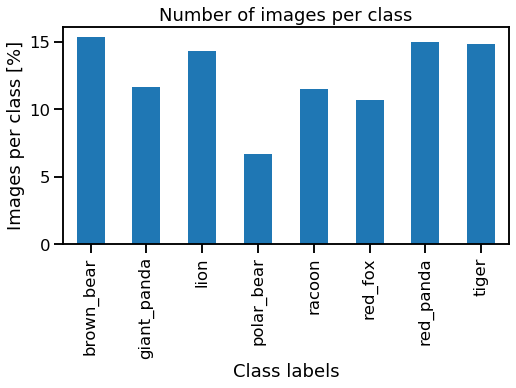

In [12]:
# How many images per class do we have?
plot_class_distribution(y_pixel, metainfo)

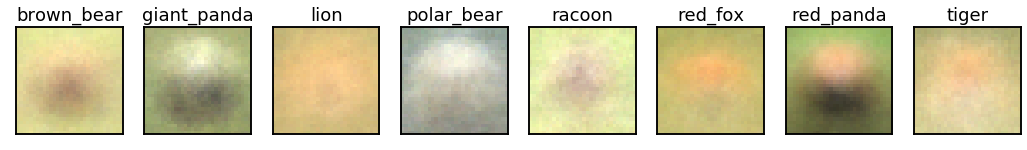

In [13]:
# What does the average image of each class look like?
plot_class_average(X_pixel, y_pixel, metainfo)

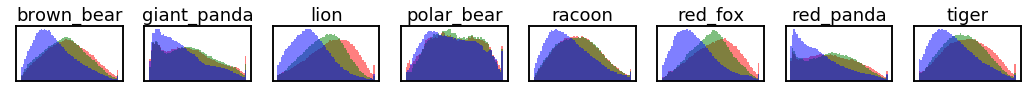

In [14]:
# What does the average RGB color profile look like per class?
plot_class_RGB(X_pixel, y_pixel, metainfo)

## 2.2. Feature Engineering

In [15]:
# Extract RGB color profiles for each image individually
X_rgb, y_rgb = extract_RGB_features(X_pixel, y_pixel)

In [16]:
# Extract features according to MobileNet (Neural Network)
X_nn, y_nn = extract_neural_network_features()

Building model.
Found 4105 images belonging to 8 classes.
Extracting features.


## 2.3 Recap before Modeling

Each image from our original cleaned dataset is now represented in three different ways:
- `X_pixel`: In its original pixel format.
- `X_rgb`: Represented by its RGB color profile only.
- `X_nn`: Represented by its MobileNet (Neural Network) features

To better understand what this means, let's plot an image in these three representations.

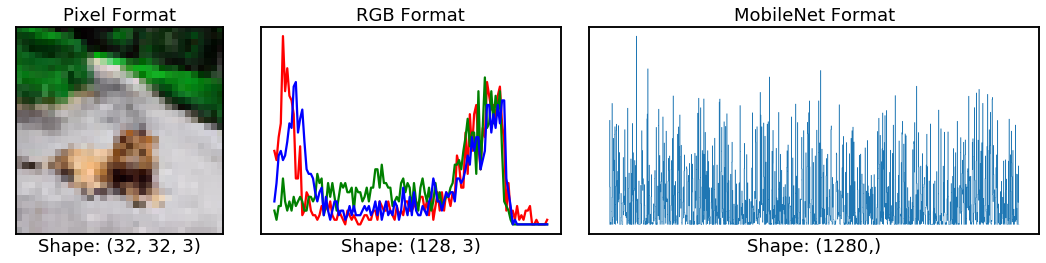

In [17]:
plot_recap(X_pixel, X_rgb, X_nn)

# 3. Modeling and Analysis

## 3.1. Fit Model to Training Data

In [31]:
def model_fit(X, y, test_size=0.5, alpha_low=-3, alpha_high=5, n_steps=16, cv=2, plot_figures=False):

    # Prepare datasets
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_temp = X.reshape((len(X), -1))
    X_temp = scaler.fit_transform(X_temp)
    indexes = list(range(len(X_temp)))

    # Split Dataset into training and test set
    x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X_temp, y, indexes, test_size=test_size, random_state=0, stratify=y)

    # Model creation
    ridge = RidgeClassifier(class_weight='balanced')
    alphas = np.logspace(alpha_low, alpha_high, num=n_steps)
    clf = GridSearchCV(estimator=ridge,
                       param_grid={'alpha': alphas},
                       cv=cv, return_train_score=True,
                       n_jobs=-1, verbose=1)

    # Fit the model to the data
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        start = time.time()
        results = clf.fit(x_train, y_train)
        comp_time_total = time.time() - start

    # Plot the model fit curves
    if plot_figures:

        # Extract relevant modelling metrics
        train_scores = 100 * clf.cv_results_['mean_train_score']
        valid_scores = 100 * clf.cv_results_['mean_test_score']
        std_tr = 100 * clf.cv_results_['std_train_score']
        std_va = 100 * clf.cv_results_['std_test_score']

        plt.figure(figsize=(10, 5))
        plt.semilogx(alphas, train_scores, label='Training Set')
        plt.semilogx(alphas, valid_scores, label='Validation Set')

        # Add marker and text for best score
        x_pos = clf.best_params_['alpha']
        y_pos = 100 * clf.best_score_
        txt = '{:0.2f}%'.format(y_pos)
        plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
        plt.text(x_pos, y_pos - 7.5, txt, fontdict={'size': 18})

        # Quantify variance with ±std curves
        plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
        plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
        plt.title('Model Performance')
        plt.ylabel('Classification Accuracy [%]')
        plt.xlabel('Model Parameter [alpha]')
        
        # Adjust x-lim, y-lim, add legend and adjust layout
        plt.xlim(10**alpha_low, 10**alpha_high)
        plt.ylim(15, 105)
        plt.legend()
        plt.tight_layout()
        plt.show()

    else:
        # Provide written performance feedback
        best_score_test = clf.best_score_ * 100
        feedback_txt = 'Model trained for {:.2f}s total '.format(comp_time_total)
        feedback_txt += 'and reached an accuracy of: {:.2f}%'.format(best_score_test)
        time.sleep(0.25)
        print(feedback_txt)

    # Store everything in model
    model = {'model': results.best_estimator_,
             'best_score': results.best_score_,
             'x_train': x_train,
             'x_test': x_test,
             'y_train': y_train,
             'y_test': y_test,
             'idx_train': idx_train,
             'idx_test': idx_test}

    return model

In [32]:
model_pixel = model_fit(X_pixel, y_pixel)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    1.1s finished


Model trained for 1.34s total and reached an accuracy of: 38.21%


In [33]:
model_rgb = model_fit(X_rgb, y_rgb)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.3s finished


Model trained for 0.30s total and reached an accuracy of: 33.04%


In [34]:
model_nn = model_fit(X_nn, y_nn)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.5s finished


Model trained for 0.61s total and reached an accuracy of: 99.32%


## 3.2. Check Model Performance on Test data

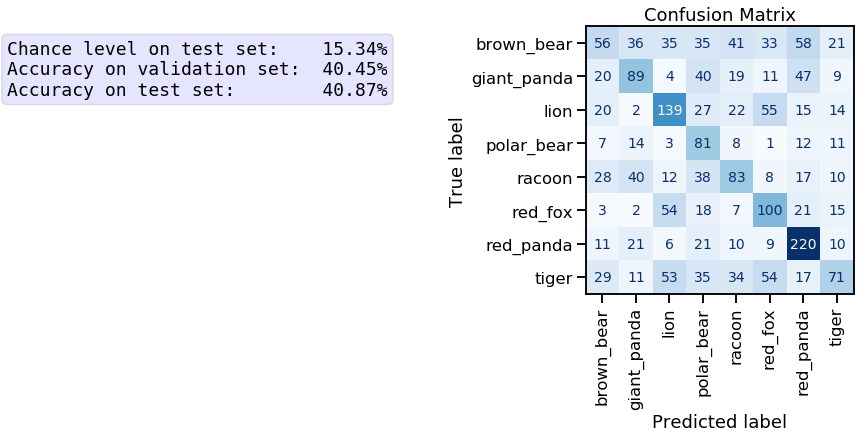

In [21]:
check_model_performance(model_pixel, metainfo)

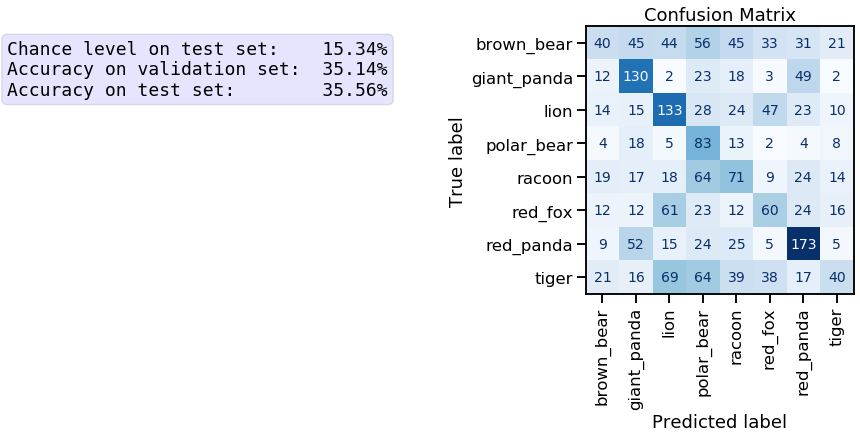

In [22]:
check_model_performance(model_rgb, metainfo)

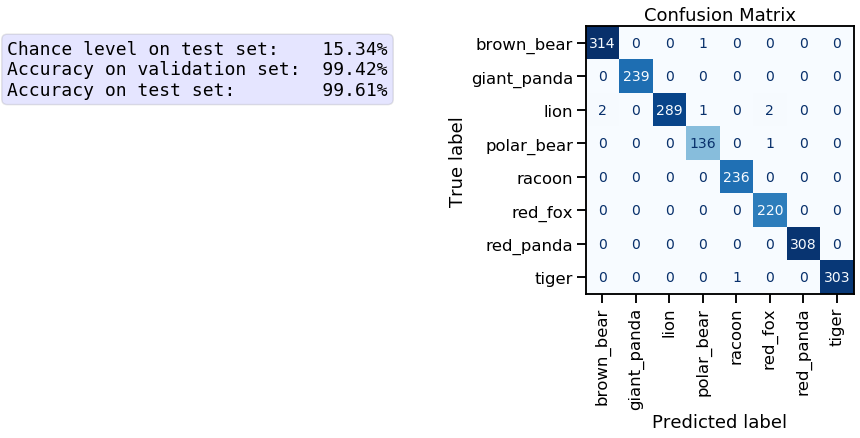

In [23]:
check_model_performance(model_nn, metainfo)

# 4. Communication & Reporting

## 4.1. Investigation of Model Performance

In [24]:
# Choose which model to investigate: 'model_pixel', 'model_rgb' or 'model_nn'
model = model_nn

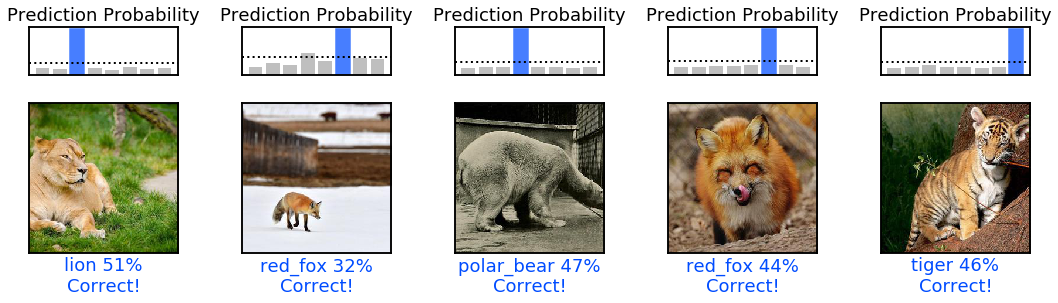

In [25]:
# Plot correct predictions
investigate_predictions(model, metainfo, show_correct=True)

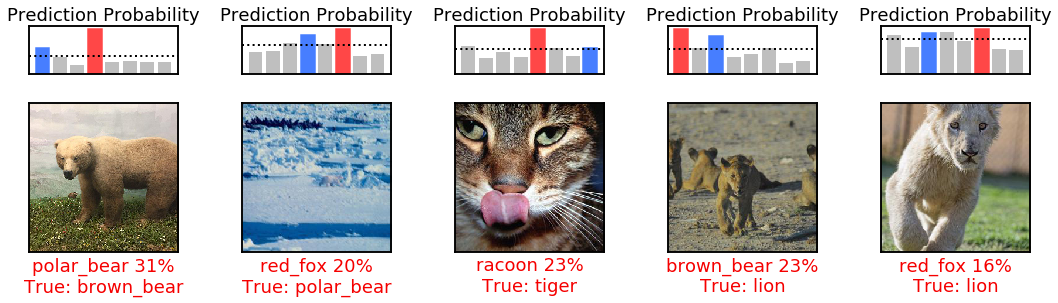

In [26]:
# Plot wrong predictions
investigate_predictions(model, metainfo, show_correct=False)

## 4.2. Try out Model Predictions on New Images

In [27]:
# Specify the URL path to an image that you would like to classify
img_url = 'https://live.staticflickr.com/7279/7017467025_8807cc82f6_b.jpg'

Feature Extraction.
Plotting report.


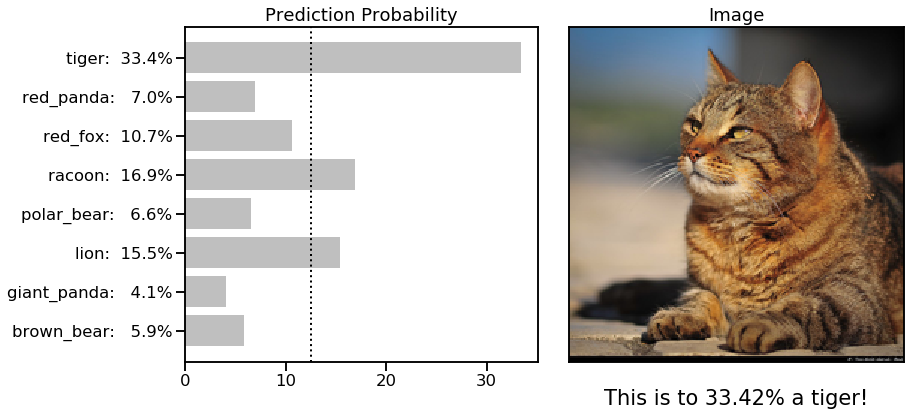

In [28]:
predict_new_image(img_url, model_nn, metainfo)

Feature Extraction.
Plotting report.


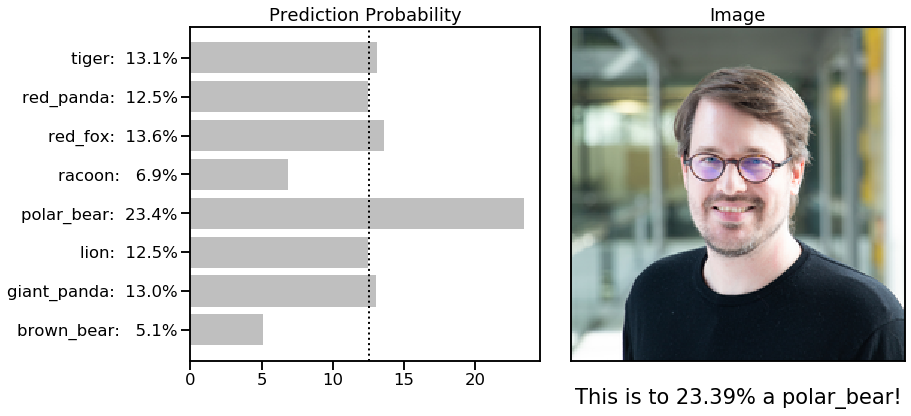

In [29]:
img_url = 'https://d33wubrfki0l68.cloudfront.net/067d6b185769f031404e927b1b70de6d5ece3e0a/d82f4/michael.1164620e.jpg'
predict_new_image(img_url, model_nn, metainfo)

In [30]:
img_url = 'www.YOUR_OWN_IMAGE.jpg'
predict_new_image(img_url, model_nn, metainfo)

MissingSchema: Invalid URL 'www.YOUR_OWN_IMAGE.jpg': No schema supplied. Perhaps you meant http://www.YOUR_OWN_IMAGE.jpg?